In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

In [36]:
df = pd.read_csv("/workspaces/Customer_Churn_Prediction_Group_06/Customer_Churn_Prediction_Group_06/dataset/churn_data.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [37]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [38]:
# Drop rows with missing TotalCharges
df.dropna(subset=['TotalCharges'], inplace=True)

In [39]:
# Drop customerID (not useful for prediction)
df.drop('customerID', axis=1, inplace=True)

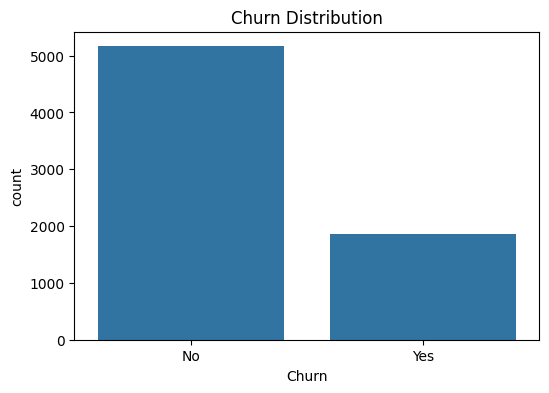

In [40]:
# Plots
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

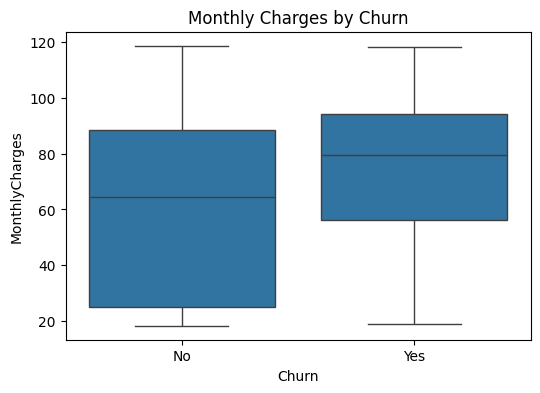

In [41]:
# Plots
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges by Churn")
plt.show()

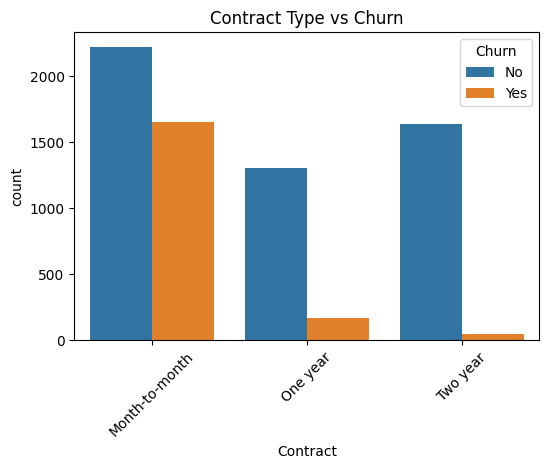

In [42]:
# Plots
plt.figure(figsize=(6,4))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title("Contract Type vs Churn")
plt.xticks(rotation=45)
plt.show()


In [43]:
# Convert target column to binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# One-hot encode categorical features
df_encoded = pd.get_dummies(df, drop_first=True)

In [44]:
# Split data into features and target
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [45]:
# Train AdaBoost Model

In [46]:

# Create AdaBoost model
model = AdaBoostClassifier(n_estimators=100, learning_rate=0.5, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7953091684434968
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.66      0.47      0.55       374

    accuracy                           0.80      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.80      0.78      1407

